In [2]:
from stable_baselines3 import SAC, TD3, PPO
import gymnasium as gym
import mujoco

print("WORKS!")


WORKS!


In [3]:
import os
import time
from typing import Dict, Any, List

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import SAC, TD3, PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback

plt.rcParams["figure.figsize"] = (8, 5)

print("Imports OK")


Imports OK


In [4]:
env_id = "InvertedDoublePendulum-v4"

env = gym.make(env_id)
obs, info = env.reset()
print("Env loaded, obs shape:", obs.shape)
env.close()


Env loaded, obs shape: (11,)


/Users/husiksargsyan/Desktop/RL-project/.venv/lib/python3.12/site-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment InvertedDoublePendulum-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


In [5]:
# ======================
# 1. Logging Callback
# ======================

class RewardLoggingCallback(BaseCallback):
    """
    Logs episode rewards during training.
    Works with Monitor wrapper.
    """

    def __init__(self, verbose: int = 0):
        super().__init__(verbose)
        self.episode_rewards = []
        self.episode_lengths = []

    def _on_step(self) -> bool:
        # Monitor puts 'episode' info in infos list
        for info in self.locals.get("infos", []):
            if "episode" in info:
                self.episode_rewards.append(info["episode"]["r"])
                self.episode_lengths.append(info["episode"]["l"])
        return True


# ======================
# 2. Environment Factory
# ======================

def make_env(env_id: str, seed: int = 0):
    """
    Returns a Monitor-wrapped, seeded Gymnasium environment.
    """
    def _init():
        env = gym.make(env_id)
        env.reset(seed=seed)
        env = Monitor(env)
        return env
    return _init

print("Utils 1 loaded")


Utils 1 loaded


In [6]:
# ======================
# 3. Training Function
# ======================

def train_agent(
    algo_name: str,
    env_id: str = "InvertedDoublePendulum-v4",
    total_timesteps: int = 150_000,
    seed: int = 0,
    hyperparams: Dict[str, Any] = None,
    log_dir: str = "./logs"
):
    """
    Train SAC / TD3 / PPO on InvertedDoublePendulum.

    Returns:
        model, callback (with episode rewards), training_time_seconds
    """
    os.makedirs(log_dir, exist_ok=True)

    if hyperparams is None:
        hyperparams = {}

    env_fn = make_env(env_id, seed)
    vec_env = DummyVecEnv([env_fn])

    if algo_name.upper() == "SAC":
        ModelClass = SAC
        default_params = dict(
            policy="MlpPolicy",
            learning_rate=3e-4,
            buffer_size=1_000_000,
            batch_size=256,
            tau=0.005,
            gamma=0.99,
            train_freq=1,
            gradient_steps=1,
            learning_starts=10_000,
            verbose=0
        )
    elif algo_name.upper() == "TD3":
        ModelClass = TD3
        default_params = dict(
            policy="MlpPolicy",
            learning_rate=1e-3,
            buffer_size=1_000_000,
            batch_size=256,
            tau=0.005,
            gamma=0.99,
            train_freq=1,
            gradient_steps=1,
            learning_starts=10_000,
            policy_delay=2,
            verbose=0
        )
    elif algo_name.upper() == "PPO":
        ModelClass = PPO
        default_params = dict(
            policy="MlpPolicy",
            learning_rate=3e-4,
            n_steps=2048,
            batch_size=64,
            n_epochs=10,
            gamma=0.99,
            gae_lambda=0.95,
            clip_range=0.2,
            verbose=0
        )
    else:
        raise ValueError(f"Unknown algo_name: {algo_name}")

    default_params.update(hyperparams)

    tb_log_dir = os.path.join(log_dir, f"{algo_name}_tb")
    os.makedirs(tb_log_dir, exist_ok=True)

    model = ModelClass(
        env=vec_env,
        tensorboard_log=tb_log_dir,
        seed=seed,
        **default_params
    )

    callback = RewardLoggingCallback()

    start_time = time.time()
    model.learn(total_timesteps=total_timesteps, callback=callback)
    training_time = time.time() - start_time

    return model, callback, training_time

print("Training function loaded")


Training function loaded


In [7]:
# ======================
# 4. Evaluation Functions
# ======================

def evaluate_deterministic_policy(
    model,
    env_id: str = "InvertedDoublePendulum-v4",
    n_eval_episodes: int = 10,
    render: bool = False
):
    """
    Evaluate the deterministic (greedy) policy.
    For SAC/TD3 this means deterministic=True.
    For PPO, deterministic=True picks the mode of the distribution.
    """
    eval_env = gym.make(env_id)
    eval_env = Monitor(eval_env)

    mean_reward, std_reward = evaluate_policy(
        model,
        eval_env,
        n_eval_episodes=n_eval_episodes,
        render=render,
        deterministic=True,
        return_episode_rewards=False
    )

    eval_env.close()
    return mean_reward, std_reward


def rollout_trajectory(
    model,
    env_id: str = "InvertedDoublePendulum-v4",
    deterministic: bool = True,
    max_steps: int = 1000
):
    """
    Run a single trajectory and return states, actions, rewards.
    """
    env = gym.make(env_id)
    obs, info = env.reset()
    states = []
    actions = []
    rewards = []

    for _ in range(max_steps):
        action, _ = model.predict(obs, deterministic=deterministic)
        next_obs, reward, terminated, truncated, info = env.step(action)

        states.append(obs)
        actions.append(action)
        rewards.append(reward)

        obs = next_obs
        if terminated or truncated:
            break

    env.close()
    return np.array(states), np.array(actions), np.array(rewards)

print("Evaluation utils loaded")


Evaluation utils loaded


In [8]:
# ======================
# 5. Plotting
# ======================

def plot_learning_curves(
    algo_results: Dict[str, List[float]],
    window: int = 10,
    save_path: str = None
):

    plt.figure()
    for algo_name, rewards in algo_results.items():
        rewards = np.array(rewards, dtype=np.float32)
        if len(rewards) == 0:
            continue
        # Moving average
        if len(rewards) >= window:
            mov_avg = np.convolve(rewards, np.ones(window)/window, mode="valid")
        else:
            mov_avg = rewards
        plt.plot(mov_avg, label=algo_name)

    plt.xlabel(f"Episode (smoothed over {window})")
    plt.ylabel("Episode Reward")
    plt.title("Learning Curves: InvertedDoublePendulum")
    plt.legend()
    plt.grid(True)

    if save_path is not None:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")

    plt.show()

print("Plotting utils loaded")


Plotting utils loaded


In [9]:
env_id = "InvertedDoublePendulum-v4"
total_timesteps = 50_000   # start small; later increase
seed = 0

algorithms = ["SAC", "TD3", "PPO"]

all_models = {}
all_callbacks = {}
training_times = {}
algo_episode_rewards = {}

for algo in algorithms:
    print(f"\n=== Training {algo} ===")
    model, callback, train_time = train_agent(
        algo_name=algo,
        env_id=env_id,
        total_timesteps=total_timesteps,
        seed=seed,
        hyperparams=None,
        log_dir="./logs"
    )
    all_models[algo] = model
    all_callbacks[algo] = callback
    training_times[algo] = train_time
    algo_episode_rewards[algo] = callback.episode_rewards

    print(f"{algo} training time: {train_time:.2f} seconds")
    print(f"{algo} episodes logged: {len(callback.episode_rewards)}")

print("\nTraining finished.")



=== Training SAC ===
SAC training time: 1222.53 seconds
SAC episodes logged: 1950

=== Training TD3 ===


/Users/husiksargsyan/Desktop/RL-project/.venv/lib/python3.12/site-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment InvertedDoublePendulum-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


TD3 training time: 145.20 seconds
TD3 episodes logged: 2271

=== Training PPO ===
PPO training time: 12.38 seconds
PPO episodes logged: 3888

Training finished.


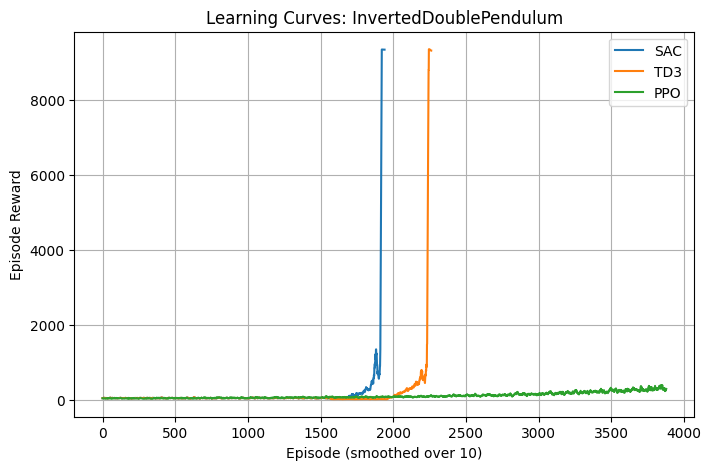

In [10]:
plot_learning_curves(algo_episode_rewards, window=10, save_path="./learning_curves.png")


In [11]:
print("=== Deterministic Policy Evaluation ===")
det_results = {}

for algo, model in all_models.items():
    mean_r, std_r = evaluate_deterministic_policy(
        model, env_id=env_id, n_eval_episodes=20, render=False
    )
    det_results[algo] = (mean_r, std_r)
    print(f"{algo}: mean reward = {mean_r:.2f} +/- {std_r:.2f}")

det_results


=== Deterministic Policy Evaluation ===
SAC: mean reward = 9354.45 +/- 2.23
TD3: mean reward = 9321.07 +/- 0.17
PPO: mean reward = 399.42 +/- 173.40


{'SAC': (np.float64(9354.446126699999), np.float64(2.228985931603568)),
 'TD3': (np.float64(9321.073452149998), np.float64(0.16968285957875373)),
 'PPO': (np.float64(399.41534955000003), np.float64(173.40485834908785))}

In [12]:
save_dir = "./trained_models"
os.makedirs(save_dir, exist_ok=True)

for algo, model in all_models.items():
    path = os.path.join(save_dir, f"{algo}_inverted_double_pendulum")
    model.save(path)
    print(f"Saved {algo} model to {path}")


Saved SAC model to ./trained_models/SAC_inverted_double_pendulum
Saved TD3 model to ./trained_models/TD3_inverted_double_pendulum
Saved PPO model to ./trained_models/PPO_inverted_double_pendulum


In [13]:
def run_hyperparam_grid(
    algo_name: str,
    env_id: str = "InvertedDoublePendulum-v4",
    total_timesteps: int = 75_000,
    seed: int = 0,
    hyperparam_grid: Dict[str, List[Any]] = None,
    base_log_dir: str = "./hyperparam_logs"
):
    
    import itertools

    if hyperparam_grid is None or len(hyperparam_grid) == 0:
        raise ValueError("hyperparam_grid must be a non-empty dict")

    os.makedirs(base_log_dir, exist_ok=True)

    param_names = list(hyperparam_grid.keys())
    param_values = list(hyperparam_grid.values())

    results = []

    for combo in itertools.product(*param_values):
        params = dict(zip(param_names, combo))
        print(f"\n[{algo_name}] Training with hyperparams: {params}")

        config_name = "_".join([f"{k}-{v}" for k, v in params.items()])
        log_dir = os.path.join(base_log_dir, f"{algo_name}_{config_name}")
        os.makedirs(log_dir, exist_ok=True)

        model, callback, train_time = train_agent(
            algo_name=algo_name,
            env_id=env_id,
            total_timesteps=total_timesteps,
            seed=seed,
            hyperparams=params,
            log_dir=log_dir
        )

        mean_r, std_r = evaluate_deterministic_policy(
            model, env_id=env_id, n_eval_episodes=10, render=False
        )

        result = {
            "algo": algo_name,
            "params": params,
            "train_time": train_time,
            "mean_reward": mean_r,
            "std_reward": std_r,
            "num_episodes": len(callback.episode_rewards)
        }
        results.append(result)

        print(f"Result: mean_reward={mean_r:.2f} +/- {std_r:.2f}, "
              f"time={train_time:.1f}s, episodes={len(callback.episode_rewards)}")

    return results

print("Hyperparam grid helper ready")


Hyperparam grid helper ready


In [14]:
sac_grid = {
    "learning_rate": [3e-4, 1e-3],
    "batch_size": [128, 256]
}

sac_hp_results = run_hyperparam_grid(
    algo_name="SAC",
    env_id=env_id,
    total_timesteps=75_000,
    seed=seed,
    hyperparam_grid=sac_grid,
    base_log_dir="./hyperparam_logs"
)

sac_hp_results



[SAC] Training with hyperparams: {'learning_rate': 0.0003, 'batch_size': 128}
Result: mean_reward=9359.04 +/- 0.27, time=227.7s, episodes=2028

[SAC] Training with hyperparams: {'learning_rate': 0.0003, 'batch_size': 256}
Result: mean_reward=9351.99 +/- 1.04, time=270.0s, episodes=1975

[SAC] Training with hyperparams: {'learning_rate': 0.001, 'batch_size': 128}
Result: mean_reward=9344.20 +/- 1.72, time=207.1s, episodes=1899

[SAC] Training with hyperparams: {'learning_rate': 0.001, 'batch_size': 256}
Result: mean_reward=9356.85 +/- 0.40, time=981.9s, episodes=1891


[{'algo': 'SAC',
  'params': {'learning_rate': 0.0003, 'batch_size': 128},
  'train_time': 227.74019932746887,
  'mean_reward': np.float64(9359.0372224),
  'std_reward': np.float64(0.27484751060276746),
  'num_episodes': 2028},
 {'algo': 'SAC',
  'params': {'learning_rate': 0.0003, 'batch_size': 256},
  'train_time': 269.99078917503357,
  'mean_reward': np.float64(9351.986921599999),
  'std_reward': np.float64(1.0428126583895696),
  'num_episodes': 1975},
 {'algo': 'SAC',
  'params': {'learning_rate': 0.001, 'batch_size': 128},
  'train_time': 207.10311198234558,
  'mean_reward': np.float64(9344.1972503),
  'std_reward': np.float64(1.7247881016057516),
  'num_episodes': 1899},
 {'algo': 'SAC',
  'params': {'learning_rate': 0.001, 'batch_size': 256},
  'train_time': 981.9437148571014,
  'mean_reward': np.float64(9356.8498468),
  'std_reward': np.float64(0.40480483652186305),
  'num_episodes': 1891}]

In [15]:
[
  {
    'algo': 'SAC',
    'params': {'learning_rate': 0.0003, 'batch_size': 128},
    'train_time': ...,
    'mean_reward': ...,
    'std_reward': ...,
    'num_episodes': ...
  },
  ...
]


[{'algo': 'SAC',
  'params': {'learning_rate': 0.0003, 'batch_size': 128},
  'train_time': Ellipsis,
  'mean_reward': Ellipsis,
  'std_reward': Ellipsis,
  'num_episodes': Ellipsis},
 Ellipsis]

In [16]:
import os
import imageio.v2 as imageio  # pip install imageio

def record_video(
    model,
    env_id: str = "InvertedDoublePendulum-v4",
    video_path: str = "video.mp4",
    max_steps: int = 1000,
    deterministic: bool = True,
    fps: int = 30,
):
    """
    Roll out one episode with the given model and save it as an mp4 video.
    """
    os.makedirs(os.path.dirname(video_path) or ".", exist_ok=True)

    # Use rgb_array rendering so we can grab frames
    env = gym.make(env_id, render_mode="rgb_array")
    obs, info = env.reset()

    frames = []

    for _ in range(max_steps):
        action, _ = model.predict(obs, deterministic=deterministic)
        obs, reward, terminated, truncated, info = env.step(action)

        frame = env.render()  # (H, W, 3) numpy array
        frames.append(frame)

        if terminated or truncated:
            break

    env.close()

    # Save to mp4
    imageio.mimsave(video_path, frames, fps=fps)
    print(f"Saved video to {video_path}")


In [17]:
pip install imageio


Note: you may need to restart the kernel to use updated packages.


In [21]:
import os
import imageio.v2 as imageio  # already installed

def record_gif(
    model,
    env_id: str = "InvertedDoublePendulum-v4",
    gif_path: str = "videos/td3_final.gif",
    max_steps: int = 1000,
    deterministic: bool = True,
    fps: int = 30,
):
    """
    Roll out one episode with the given model and save it as a GIF.
    """
    os.makedirs(os.path.dirname(gif_path) or ".", exist_ok=True)

    env = gym.make(env_id, render_mode="rgb_array")
    obs, info = env.reset()

    frames = []

    for _ in range(max_steps):
        action, _ = model.predict(obs, deterministic=deterministic)
        obs, reward, terminated, truncated, info = env.step(action)

        frame = env.render()  # (H, W, 3) numpy array
        frames.append(frame)

        if terminated or truncated:
            break

    env.close()

    # duration is seconds per frame
    duration = 1.0 / fps
    imageio.mimsave(gif_path, frames, duration=duration)
    print(f"Saved GIF to {gif_path}")



In [22]:
td3_model = all_models["TD3"]
record_gif(
    td3_model,
    env_id="InvertedDoublePendulum-v4",
    gif_path="videos/td3_final.gif",
    max_steps=1000,
    deterministic=True,
    fps=30,
)


Saved GIF to videos/td3_final.gif


In [23]:
sac_model = all_models["SAC"]
record_gif(sac_model, gif_path="videos/sac_final.gif")

ppo_model = all_models["PPO"]
record_gif(ppo_model, gif_path="videos/ppo_final.gif")


Saved GIF to videos/sac_final.gif
Saved GIF to videos/ppo_final.gif
